In [118]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
import json
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 5]

In [119]:
with open("../export/image_catalogue.json") as ic_file:
    image_catalog = json.load(ic_file)
    types_map = [v["type"] for k, v in sorted(image_catalog.items()) if k.isnumeric()]

In [120]:
rating_files = glob.glob("../export/*_rating.csv")
rating_files.sort()
rating_files[-1]

'../export/20221217-112102_rating.csv'

In [121]:
questions = ["Fictional/Real", "Human-made/Human-like", "Eerie/Ordinary", "Unsettling/Plain", "Creepy/Dull",
             "Hair-raising/Unemotional", "Hostile/Friendly", "Grumpy/Cheerful", "Cold-hearted/Warm-hearted "]

In [122]:
ratings = pd.read_csv(rating_files[-1], index_col=["index"],
                      names=["index", "timestamp", "img"] + questions + ["uid"])
ratings["type"] = [types_map[img] for img in ratings["img"]]

# Image Distribution

<AxesSubplot: >

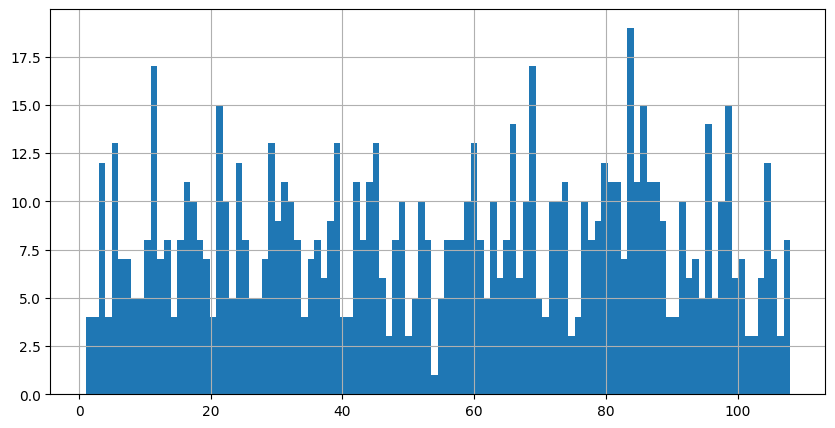

In [123]:
ratings["img"].hist(bins=max(ratings["img"]))

# Ratings Distribution

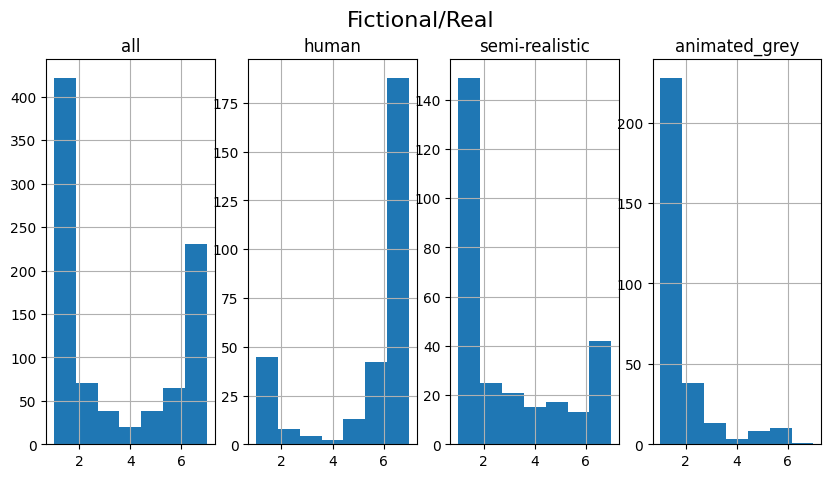

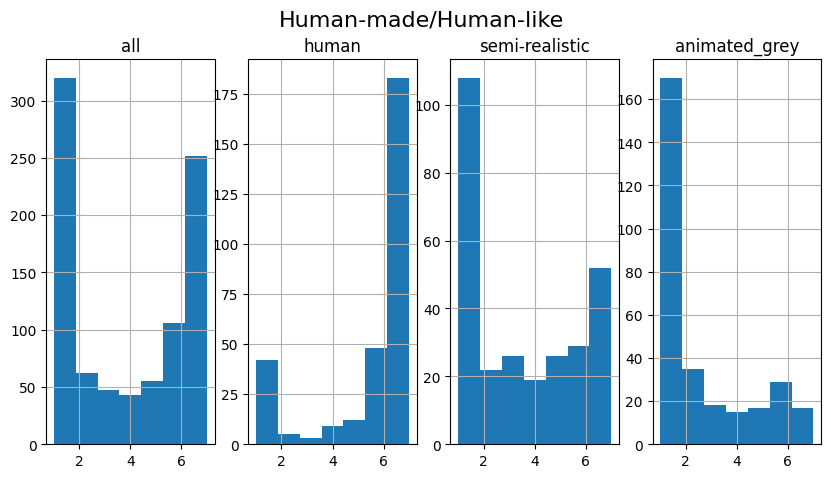

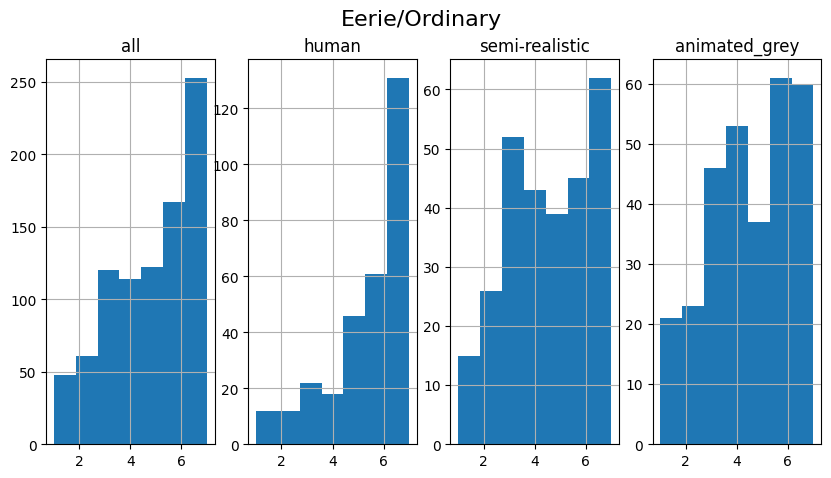

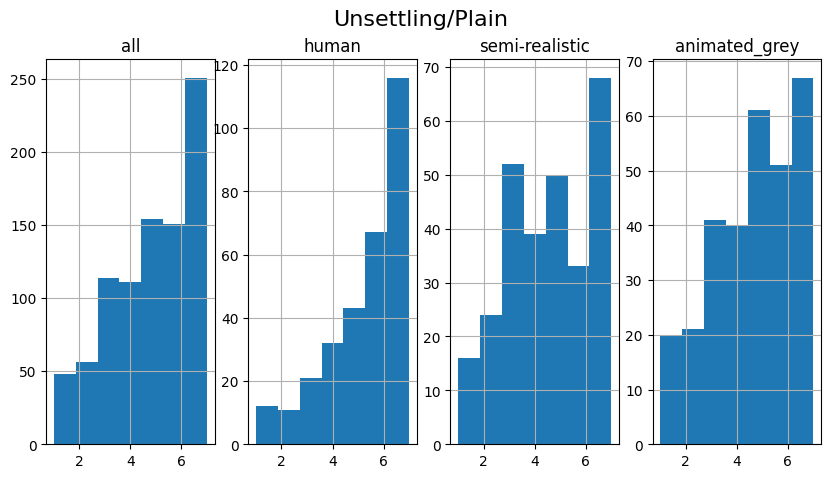

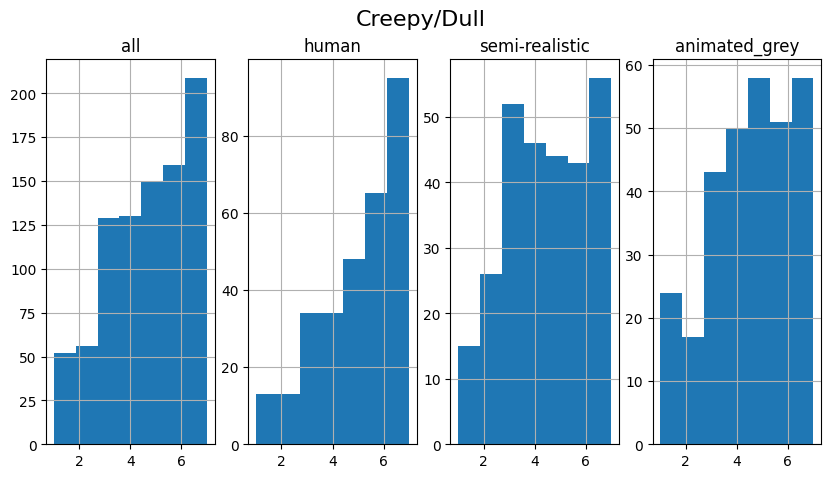

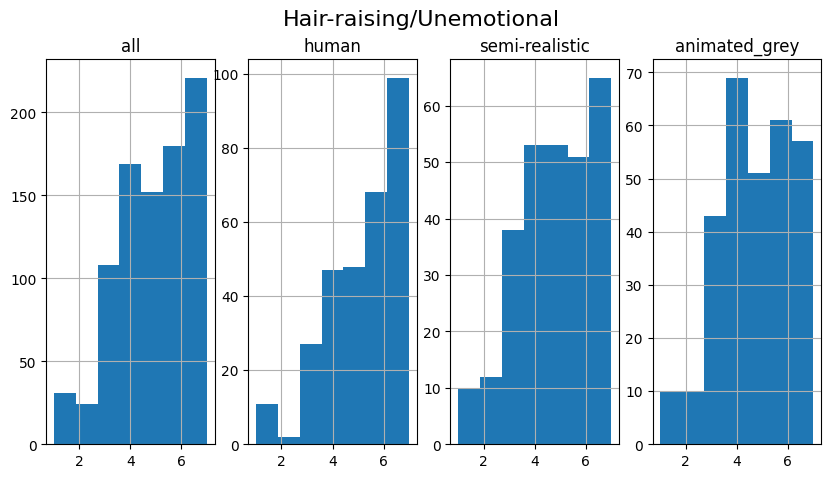

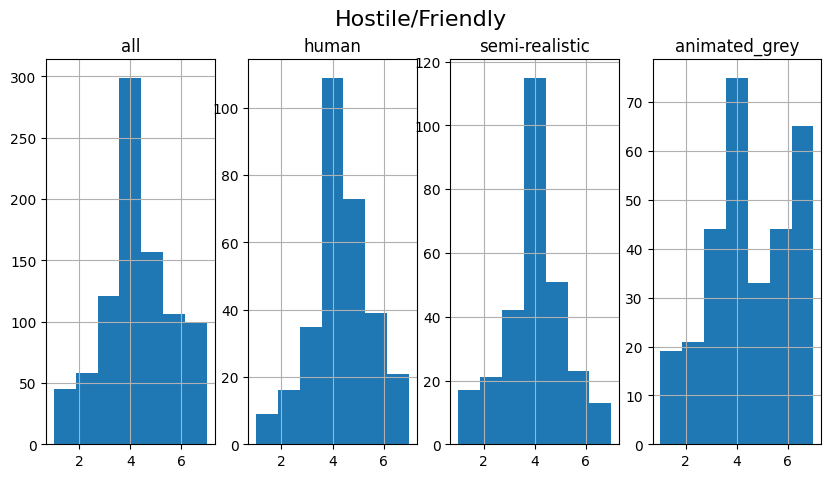

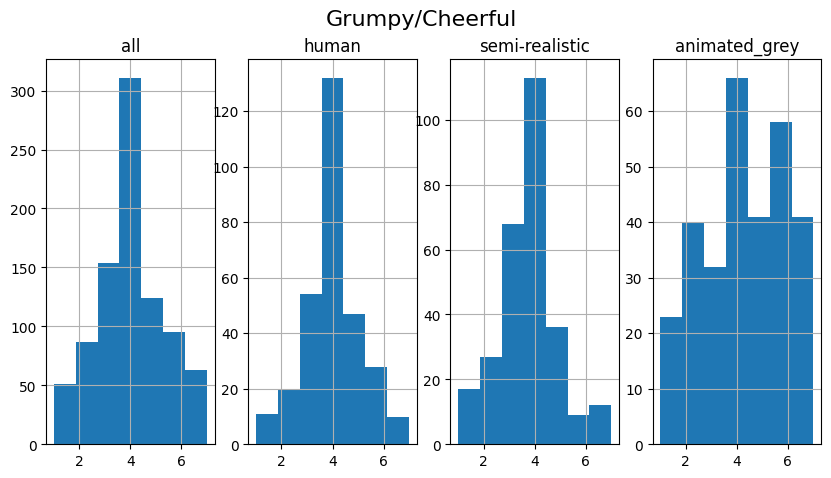

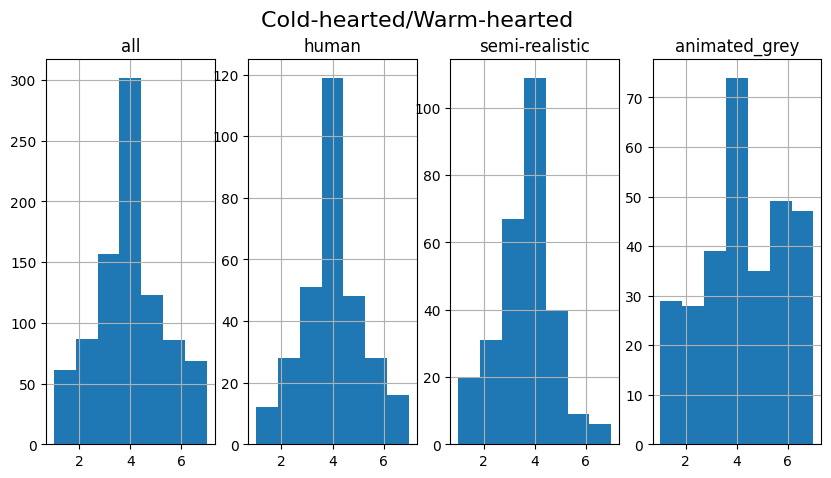

In [124]:
for column in questions:
    fig, axes = plt.subplots(1, 4)
    fig.suptitle(column, fontsize=16)
    ratings[column].hist(bins=max(ratings[column]), ax=axes[0])
    axes[0].set_title('all')
    ratings[ratings["type"] == "human"][column].hist(bins=1+max(ratings[column])-min(ratings[column]), ax=axes[1])
    axes[1].set_title('human')
    ratings[ratings["type"] == "semi-realistic"][column].hist(bins=1+max(ratings[column])-min(ratings[column]), ax=axes[2])
    axes[2].set_title('semi-realistic')
    ratings[ratings["type"] == "animated_grey"][column].hist(bins=1+max(ratings[column])-min(ratings[column]), ax=axes[3])
    axes[3].set_title('animated_grey')
    plt.show()